## 03 - Modelling

## Optional - Colab Setup

In [ ]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [ ]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [ ]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [ ]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    import pynvml
    setup_rapids()
    
    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 112kB 21.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 64.8MB 53kB/s 
     |████████████████████████████████| 14.7MB 148kB/s 
     |████████████████████████████████| 10.9MB 30.7MB/s 
  Created wheel for sparse-dot-topn: filename=sparse_dot_topn-0.2.9-cp36-cp36

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2020-05-05 15:12:38--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-05-05 15:12:38--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   117MB/s    in 0.5s    

2020-05-05 15:12:39 (117 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_

## Imports

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,  StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tqdm.pandas()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [ ]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [ ]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [ ]:
from cuml import LinearRegression, RandomForestRegressor, Ridge, Lasso

In [ ]:
from catboost import CatBoostRegressor

## Loading Data

In [ ]:
metadata_df, image_embeddings_df = tuple(load_from_pkl(i,DATA_PATH) for i in ('metadata','image_embeddings'))
df = metadata_df.merge(image_embeddings_df,how='inner',on='release_id')

After merging, we will take care of additional outliers that need to be addressed, namely for ``number_of_tracks``, ``running_time``, and the UMAP dimensionality reduction outputs, which were discussed in 02-Visualization&Cleaning. ``number_of_tracks`` and ``running_time`` suffer from massive outlier values which skew the distribution of the features and as such must be taken out of contention. For the case of ``running_time``, we remove those albums with that last over 3 hours, in the interest of focusing our attention on albums of a normal length

In [ ]:
df = OutlierRemover(features=['number_of_tracks'] + [i for i in df.columns if 'umap' in i]).fit_transform(df[(df['running_time'] < 180) | (df['running_time'].isna())])

In [ ]:
del metadata_df, image_embeddings_df

In [14]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'image_umap_'
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value)

In [ ]:
units_for_sale_imputer = SimpleImputer(strategy='constant',fill_value=0)
average_rating_imputer = SimpleImputer(strategy='mean')

In [ ]:
X_tr['units_for_sale'] = units_for_sale_imputer.fit_transform(X_tr['units_for_sale'].values.reshape(-1,1))
X_te['units_for_sale'] = units_for_sale_imputer.transform(X_te['units_for_sale'].values.reshape(-1,1))

In [ ]:
X_tr['average_rating'] = average_rating_imputer.fit_transform(X_tr['average_rating'].values.reshape(-1,1))
X_te['average_rating'] = average_rating_imputer.transform(X_te['average_rating'].values.reshape(-1,1))

In [ ]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

In [ ]:
del df

## Setting up Dummy Regression for baseline

In [ ]:
dummy_regressor = DummyRegressor(strategy='mean')

In [23]:
dummy_regressor.fit(X_tr,np.log(y_tr).values)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [ ]:
dummy_pred = dummy_regressor.predict(X_te)

In [25]:
dummy_r2 = r2_score(y_te,np.exp(dummy_pred))
dummy_r2

-0.0794313676224736

In [26]:
dummy_mae = mean_absolute_error(y_te,np.exp(dummy_pred))
dummy_mae

10.5310293416189

## Linear Regression - Record Store

In [ ]:
record_store_regression_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [ ]:
record_store_regression_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title', 'release_id'
])

In [ ]:
record_store_regression_processing = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_regression_removal_columns)),
    ('preprocessing',record_store_regression_transformer),
    ('scaler', RobustScaler()),                             
])

record_store_lr_pipe = Pipeline([
    ('processing', record_store_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize': [True, False]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [31]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   18.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='va...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=Tr

In [32]:
record_store_lr_pipe.steps[-1][-1].best_score_

-0.583877642870599

In [33]:
record_store_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [34]:
record_store_lr_r2 = r2_score(y_te,np.exp(record_store_lr_pred))
record_store_lr_r2

-150.15149093972255

In [35]:
record_store_lr_mae = mean_absolute_error(y_te,np.exp(record_store_lr_pred))
record_store_lr_mae 

9.499828183381744

## Linear Regression - Full Information

In [ ]:
full_information_regression_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [ ]:
full_information_columns = set([
    'units_for_sale','community_have','community_want','average_rating','rating_count'
])
full_information_regression_removal_columns = record_store_regression_removal_columns - full_information_columns

In [ ]:
full_information_regression_processing = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(full_information_regression_removal_columns)),
    ('preprocessing',full_information_regression_transformer),
    ('scaler', RobustScaler()),
])

full_information_lr_pipe = Pipeline([
    ('processing', full_information_regression_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [39]:
full_information_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.4s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='va...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=Tr

In [40]:
full_information_lr_pipe['lr'].best_score_

-0.5414585510993827

In [41]:
full_information_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [42]:
r2_score(y_te,np.exp(full_information_lr_pred))

-150.15149093972255

In [43]:
mean_absolute_error(y_te,np.exp(full_information_lr_pred))

9.499828183381744

## Ridge Regression - Record Store

In [ ]:
record_store_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_regression_removal_columns)),
    ('preprocessing',record_store_regression_transformer),
    ('scaler', RobustScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.linspace(1e-3,1e3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [45]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.9s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f1d8f2b1db0>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.3

In [ ]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

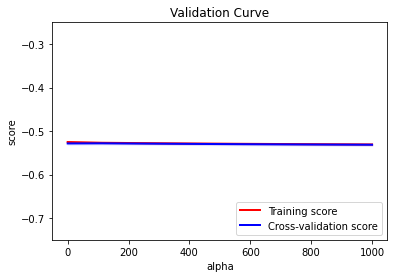

In [47]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [48]:
record_store_ridge_pipe['ridge'].best_score_

-0.5280974967532046

In [49]:
record_store_ridge_pipe['ridge'].best_params_

{'alpha': 111.11200000000001}

In [50]:
record_store_ridge_pred = record_store_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [51]:
r2_score(y_te,np.exp(record_store_ridge_pred))

-346.03739937484784

In [52]:
mean_absolute_error(y_te,np.exp(record_store_ridge_pred))

9.987211622603766

## Ridge - Full Information

In [ ]:
full_information_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(full_information_regression_removal_columns)),
    ('preprocessing',full_information_regression_transformer),
    ('scaler', StandardScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.logspace(-3,3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [54]:
full_information_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f1d7b7ef130>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469

In [ ]:
plotter = GridSearchPlotter(full_information_ridge_pipe['ridge'])

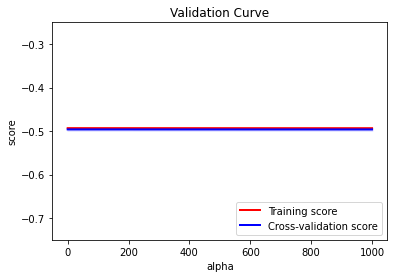

In [56]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [57]:
full_information_ridge_pipe['ridge'].best_score_

-0.49614492666793303

In [58]:
full_information_ridge_pipe['ridge'].best_params_

{'alpha': 46.41588833612773}

In [59]:
full_information_ridge_pred = full_information_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [60]:
r2_score(y_te,np.exp(full_information_ridge_pred))

-4111.901659084013

In [61]:
mean_absolute_error(y_te,np.exp(full_information_ridge_pred))

14.584179068917324

## Random Forest - Record Store

In [ ]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
]
record_store_random_forest_removal_columns.extend(
    column_store._indicator
)
record_store_random_forest_removal_columns = set(record_store_random_forest_removal_columns)

In [ ]:
record_store_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor()

record_store_random_forest_search_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

record_store_random_forest_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [64]:
record_store_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                              

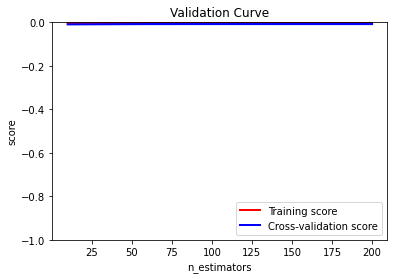

In [65]:
record_store_random_forest_plotter = GridSearchPlotter(record_store_random_forest_search_pipe.steps[-1][1])
record_store_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [66]:
record_store_random_forest_search_pipe.steps[-1][1].best_score_

-0.007035530588829418

In [67]:
record_store_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 200}

In [68]:
record_store_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                 RandomForestR

In [ ]:
record_store_random_forest_te_pred = record_store_random_forest_pipe.predict(X_te)

In [70]:
r2_score(y_te,np.exp(record_store_random_forest_te_pred))

-0.0840500228515495

In [71]:
mean_absolute_error(y_te,np.exp(record_store_random_forest_te_pred))

10.48120340759418

## Random Forest - Full Information

In [ ]:
full_information_random_forest_removal_columns = record_store_random_forest_removal_columns - full_information_columns

In [ ]:
full_information_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(full_information_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.astype(np.float32)))
])

full_information_random_forest_search_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

full_information_random_forest_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [74]:
full_information_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                              

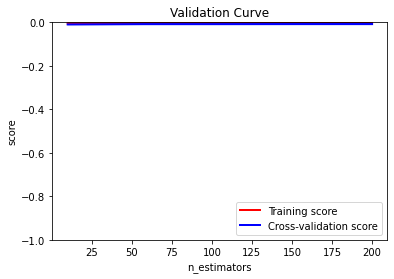

In [75]:
full_information_random_forest_plotter = GridSearchPlotter(full_information_random_forest_search_pipe.steps[-1][1])
full_information_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [76]:
full_information_random_forest_search_pipe.steps[-1][1].best_score_

-0.007178747814856755

In [77]:
full_information_random_forest_search_pipe.steps[-1][1].best_params_

{'n_estimators': 200}

In [78]:
full_information_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'format_name',
                                                           'master_id',
                                                           'year'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_u...
                 RandomForestR

In [ ]:
full_information_random_forest_te_pred = full_information_random_forest_pipe.predict(X_te)

In [80]:
r2_score(y_te,np.exp(full_information_random_forest_te_pred))

-0.0839987999272489

In [81]:
mean_absolute_error(y_te,np.exp(full_information_random_forest_te_pred))

10.480869470339867

## Catboost - Record Store

In [ ]:
record_store_catboost_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
])
record_store_catboost_removal_columns = record_store_catboost_removal_columns.union(column_store._geography_country)

In [ ]:
record_store_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns)),
])

catboost = CatBoostRegressor(
    random_seed=0,
    cat_features=['year','format_text','master_id','format_name','artist','label','country'],
    boosting_type='Ordered',
    n_estimators=100,
    learning_rate=0.1,
    l2_leaf_reg=3,
    border_count=170,
    max_depth=10,
)

record_store_catboost_grid_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=-1,
        cv=KFold(n_splits=5,shuffle=True),
        verbose=1,
        scoring='neg_mean_absolute_error',
        return_train_score=True)
    )
])

record_store_catboost_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('catboost',catboost)
])

In [84]:
record_store_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.8min finished


0:	learn: 0.8674830	total: 381ms	remaining: 37.8s
1:	learn: 0.8506953	total: 631ms	remaining: 30.9s
2:	learn: 0.8358839	total: 893ms	remaining: 28.9s
3:	learn: 0.8232962	total: 1.15s	remaining: 27.5s
4:	learn: 0.8126065	total: 1.41s	remaining: 26.7s
5:	learn: 0.8038130	total: 1.67s	remaining: 26.2s
6:	learn: 0.7955038	total: 1.94s	remaining: 25.8s
7:	learn: 0.7893566	total: 2.2s	remaining: 25.3s
8:	learn: 0.7833777	total: 2.47s	remaining: 25s
9:	learn: 0.7769985	total: 2.73s	remaining: 24.6s
10:	learn: 0.7714056	total: 3s	remaining: 24.3s
11:	learn: 0.7660585	total: 3.27s	remaining: 24s
12:	learn: 0.7616219	total: 3.52s	remaining: 23.6s
13:	learn: 0.7581175	total: 3.79s	remaining: 23.3s
14:	learn: 0.7551021	total: 4.05s	remaining: 22.9s
15:	learn: 0.7521717	total: 4.3s	remaining: 22.6s
16:	learn: 0.7487425	total: 4.56s	remaining: 22.3s
17:	learn: 0.7460573	total: 4.8s	remaining: 21.9s
18:	learn: 0.7438011	total: 5.05s	remaining: 21.5s
19:	learn: 0.7408095	total: 5.31s	remaining: 21.2s


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'coun...
                          verbose=False)),


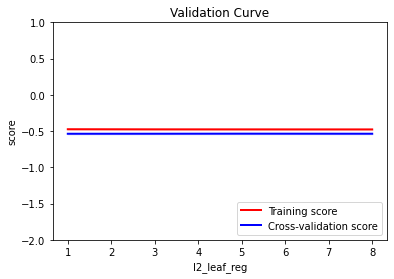

In [87]:
record_store_catboost_plot = GridSearchPlotter(record_store_catboost_grid_pipe.steps[-1][1])
record_store_catboost_plot.plot_validation_curve(parameter='l2_leaf_reg',ylim=(-2,1))

In [88]:
record_store_catboost_grid_pipe.steps[-1][1].best_score_

-0.5344958049038084

In [89]:
record_store_catboost_grid_pipe.steps[-1][1].best_params_

{'l2_leaf_reg': 5}

In [90]:
record_store_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8683268	total: 920ms	remaining: 1m 31s
1:	learn: 0.8487862	total: 1.74s	remaining: 1m 25s
2:	learn: 0.8325626	total: 2.56s	remaining: 1m 22s
3:	learn: 0.8188136	total: 3.37s	remaining: 1m 20s
4:	learn: 0.8044752	total: 4.17s	remaining: 1m 19s
5:	learn: 0.7918488	total: 4.98s	remaining: 1m 18s
6:	learn: 0.7815925	total: 5.78s	remaining: 1m 16s
7:	learn: 0.7726575	total: 6.58s	remaining: 1m 15s
8:	learn: 0.7650130	total: 7.43s	remaining: 1m 15s
9:	learn: 0.7581909	total: 8.26s	remaining: 1m 14s
10:	learn: 0.7523529	total: 9.09s	remaining: 1m 13s
11:	learn: 0.7439245	total: 9.91s	remaining: 1m 12s
12:	learn: 0.7370510	total: 10.7s	remaining: 1m 11s
13:	learn: 0.7312740	total: 11.5s	remaining: 1m 10s
14:	learn: 0.7261897	total: 12.3s	remaining: 1m 9s
15:	learn: 0.7217925	total: 13.2s	remaining: 1m 9s
16:	learn: 0.7184554	total: 14s	remaining: 1m 8s
17:	learn: 0.7154204	total: 14.8s	remaining: 1m 7s
18:	learn: 0.7128159	total: 15.6s	remaining: 1m 6s
19:	learn: 0.7105076	total: 1

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'coun...
                                           

In [ ]:
record_store_catboost_te_pred = record_store_catboost_pipe.predict(X_te)

In [92]:
r2_score(y_te,np.exp(record_store_catboost_te_pred))

0.21872335319058356

In [93]:
mean_absolute_error(y_te,np.exp(record_store_catboost_te_pred))

8.131653648545857

## CatBoost - Full Information

In [ ]:
full_information_catboost_removal_columns = record_store_catboost_removal_columns - full_information_columns

In [ ]:
full_information_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(full_information_catboost_removal_columns)),
])

full_information_catboost_grid_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={            
            #'learning_rate': np.logspace(-3,1,5),
            #'border_count': np.linspace(1,200,5),
            'l2_leaf_reg': [1,3,5,8],
        },
        n_jobs=3,
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=50,
        return_train_score=True)
    )
])

full_information_catboost_pipe = Pipeline([
    ('processing', full_information_catboost_processing_pipe),
    ('catboost',catboost)
])

In [96]:
full_information_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample).values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   56.9s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   58.1s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   60.0s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done  16 out of  20 | elapsed:  6.7min remaining:  1.7min
[Parallel(n_jobs=3)]: Done  17 out of  20 | elapsed:  6.7min remai

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                '...
                          verbose=False)),


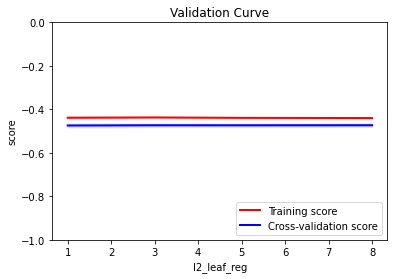

In [97]:
full_information_catboost_plot = GridSearchPlotter(full_information_catboost_grid_pipe.steps[-1][1])
full_information_catboost_plot.plot_validation_curve(parameter='l2_leaf_reg',ylim=(-1,0))

In [98]:
full_information_catboost_grid_pipe.steps[-1][1].best_score_

-0.4726532803660488

In [99]:
full_information_catboost_grid_pipe.steps[-1][1].best_params_

{'l2_leaf_reg': 8}

In [100]:
full_information_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8567151	total: 910ms	remaining: 1m 30s
1:	learn: 0.8272267	total: 1.78s	remaining: 1m 27s
2:	learn: 0.8014225	total: 2.64s	remaining: 1m 25s
3:	learn: 0.7795100	total: 3.48s	remaining: 1m 23s
4:	learn: 0.7610550	total: 4.33s	remaining: 1m 22s
5:	learn: 0.7452602	total: 5.17s	remaining: 1m 20s
6:	learn: 0.7318303	total: 6.02s	remaining: 1m 20s
7:	learn: 0.7197181	total: 6.89s	remaining: 1m 19s
8:	learn: 0.7083631	total: 7.72s	remaining: 1m 18s
9:	learn: 0.6978462	total: 8.57s	remaining: 1m 17s
10:	learn: 0.6892118	total: 9.41s	remaining: 1m 16s
11:	learn: 0.6818231	total: 10.3s	remaining: 1m 15s
12:	learn: 0.6752963	total: 11.1s	remaining: 1m 14s
13:	learn: 0.6697786	total: 12s	remaining: 1m 13s
14:	learn: 0.6650329	total: 12.8s	remaining: 1m 12s
15:	learn: 0.6602509	total: 13.7s	remaining: 1m 11s
16:	learn: 0.6554982	total: 14.5s	remaining: 1m 10s
17:	learn: 0.6510705	total: 15.3s	remaining: 1m 9s
18:	learn: 0.6473560	total: 16.2s	remaining: 1m 8s
19:	learn: 0.6440682	total

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'country_albania',
                                                                'country_algeria',
                                                                'country_andorra',
                                                                'country_angola',
                                                                'country_argentina',
                                                                'country_armenia',
                                                                '...
                                           

In [ ]:
full_information_catboost_te_pred = full_information_catboost_pipe.predict(X_te)

In [102]:
r2_score(y_te,np.exp(full_information_catboost_te_pred))

0.35490931656800606

In [103]:
mean_absolute_error(y_te,np.exp(full_information_catboost_te_pred))

7.385317052304779

## Identification of Feature Importances

In [ ]:
feature_importance_transformation_pipe = full_information_catboost_processing_pipe.fit(X_tr,np.log(y_tr).values)
full_information_catboost_feature_importances = dict(zip(
    feature_importance_transformation_pipe.transform(X_te).columns,
    full_information_catboost_pipe.steps[-1][-1].feature_importances_
))

In [105]:
pd.Series(full_information_catboost_feature_importances).sort_values(ascending=False).head(20)

community_want                        21.105690
country                               20.592940
units_for_sale                        15.812728
format_name                            9.739488
year                                   6.131048
label                                  5.305325
artist                                 4.421464
community_have                         3.245261
average_rating                         1.961327
master_id                              1.206606
format_quantity                        1.155218
superregion_americas                   0.945520
format_text                            0.941341
superregion_europe                     0.790658
style_Easy Listening                   0.685281
format_description_Reissue             0.624144
format_description_Club Edition        0.604669
format_description_Promo               0.591190
format_description_Limited Edition     0.557363
number_of_tracks                       0.513563
dtype: float64